Yapay öğrenmede, verilerle model parametresi arasındaki hatayı asgariye indiren parametreleri bulmaya çalışırız. Bunun için en dik iniş, BFGS gibi eniyileme yöntemlerini kullanabiliriz. Hata fonksiyonu, **bütün** veri noktalarının hatalarının toplamı olduğu için çok sayıda veri kullanırken  hesaplama yükü çok ağır olacaktır. Bu tür özel eniyileme yöntemlerinde _stokastik iniş_ adı verilen bir yöntem çok başarılı olur.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

## MNIST elyazısı rakamlar verisi

MNIST verisinde 0-9 arası elle yazılmış rakam görüntüleri bulunur. Her bir rakam 28x28 piksellik bir görüntü olarak kodlanmıştır. Her bir piksel için 0-255 arası bir gri seviyesi verilir. Öğrenme kümesinde 60 000, deneme kümesinde 10 000 rakam vardır.

Bu derste, işleme hızı amacıyla sadece 3 ve 8 rakamlarına ait verileri kullanacağız. Kullanacağımız veri dosyaları `data` dizini altında `mnist_train_3_8.csv` ve `mnist_test_3_8.csv`.

MNIST verilerinin tamamına erişmek için: http://yann.lecun.com/exdb/mnist/ Aynı verileri CSV formunda [şuradan indirebilirsiniz](https://pjreddie.com/projects/mnist-in-csv/).

Dosyadaki her bir satırda 785 sütun var. İlk sütun rakamın gerçek değeri. Kalan 784 sütun ise görüntü piksellerinin gri değerlerinin satır satır yanyana yazılmasıyla elde ediliyor.

Öğrenme dosyasını yükleyip ilk kırk rakamın nasıl göründüğüne bakalım.

In [2]:
train = np.loadtxt("data/mnist_train_3_8.csv",delimiter=",")

Her bir veri noktasının ilk elemanı, taranan rakamın gerçek değeridir. Piksel değerleri ikinci elemandan başlar.

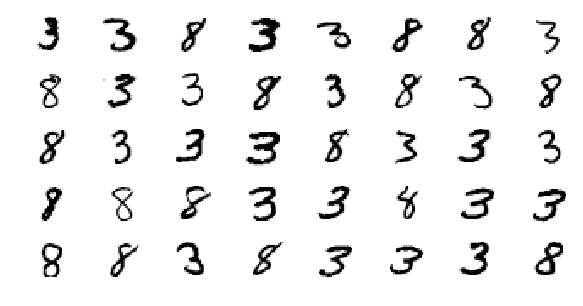

In [3]:
plt.figure(figsize=(10,5))
for i in range(1,41):
    plt.subplot(5,8,i)
    plt.imshow(train[i,1:].reshape((28,28)),cmap="Greys")
    plt.axis("off")

## Lojistik regresyonla sınıflandırma

Elimizde bir _güdümlü ikili sınıflandırma problemi_ var: 3 ve 8'leri birbirinden ayırmayı öğrenmek istiyoruz. Bu tip problemler için en temel ve yaygın modellerden biri _lojistik regresyon_ (veya, s-biçimli bağlanım) modelidir.

Her bir veri noktasını 0 veya 1 ile etiketleyelim. Eğer kodlanan rakam 3 ise etiket 1, rakam 8 ise etiket 0 olsun. _i_ numaralı veri noktasının etiketine _y<sup>(i)</sup>_ diyelim. Belli bir _x_ görüntüsü (784 uzunlukta gri-değer vektörü) verildiğinde, bu görüntüde 3 rakamı olması olasılığını, yani ilişkili etiketin 1 olması olasılığını, şu şekilde _varsayalım_:

$$P(y=1 | x) = \frac{1}{1+\exp(-\theta^T x)} \equiv h_\theta (x)$$

Aynı şekilde, görüntüde 8 olması olasılığı da şöyle olur:

$$P(y=0\ |\ x) = 1- P(y=1|x) = 1 - h_\theta(x)$$

Bu varsayım, lojistik regresyon modelini oluşturur. Bu ifadelerde $\theta = (\theta_0, \theta_1,\ldots,\theta_{784})$ vektörü henüz bilinmeyen parametrelerimizdir. Öğrenme algoritması, modele en iyi uyan $\theta$ vektörünü belirler.

Önemli not: $\theta$ vektörünün boyu öznitelik vektöründen bir fazladır. $\theta_0$ parametresi _yanlılık terimi_ olarak anılır. Matematiksel yazım kolaylığı için bütün _x_ vektörlerine yapay bir _x<sub>0</sub>_ özniteliği ekleriz ve her biri için bu öznitelik değerini 1'e sabitleriz.

Lojistik regresyon modelinde aşağıdaki fonksiyonu minimize edecek $\theta$'yı bulmak amaçlanır.

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}\underbrace{\left[ y^{(i)} \log\left(h_\theta(x^{(i)})\right)
+ (1-y^{(i)}) \log\left(1-h_\theta(x^{(i)})\right) \right]}_{J_i(\theta)}$$

In [4]:
def model(x, theta):
    # 1 / (1 + exp(-x*theta)
    # theta[0] yanlılık terimidir ve her zaman x[0] = 1 varsayılır.
    
    z = np.dot(x, theta)
   
    # z'nin aşırı büyüyüp overflow yaratmaması için iki yönden kısıtla:
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    
    return 1/(1+np.exp(-z))

def ortsapma(X,y,theta):
    z = np.dot(X,theta)
    if np.isscalar(z):
        z = 100 if z>100 else -100 if z<-100 else z
    else: # z bir vektörse sadece gerekli elemanları kısıtla.
        z[z>100] = 100
        z[z<-100] = -100
    J = (1 - y)*z + np.log(1 + np.exp(-z))
    return sum(J)/X.shape[0]

## Stokastik iniş ile eniyileme

Yukarıdaki $J(\theta)$ fonksiyonunu daha önce gördüğümüz yöntemlerle minimize edebiliriz. Ancak o yöntemler her optimizasyon adımında verinin tamamını kullanırlar. Elimizde çok büyük sayıda veri noktası varsa bu yaklaşım çok uzun sürebilir, hatta bilgisayarın belleği yetersiz kalabilir.

Stokastik iniş algoritması, en dik iniş algoritmasına benzer, ama daha basit bir adım atarız.

En dik iniş algoritmasında her adımda parametre vektörü $\theta$ şu şekilde güncellenir:

$$\theta \leftarrow \theta - \frac{\alpha}{m} \nabla \sum J_i(\theta)$$

Stokastik inişte ise her adımda rastgele bir _i_ terimi seçer, güncellemeyi sadece o terimin gradyanıyla yaparız.

$$\theta \leftarrow \theta - \frac{\alpha}{m} \nabla J_i(\theta) $$

Lojistik regresyonda sapma teriminin türevinin $\nabla J_i(\theta) = x^{(i)} \left(h_\theta(x^{(i)}) - y^{(i)}\right)$ olduğu görülebilir. O zaman, güncelleme adımı şöyle olur:

$$\theta \leftarrow \theta - \frac{\alpha}{m} x^{(i)} \left(h_\theta(x^{(i)}) - y^{(i)}\right) $$

Ardarda rastgele terimler seçerek yeni adımlar atarız ve yakınsayana kadar takip ederiz.

Stokastik iniş algoritması bütün veri yerine rastgele örnekleri kullandığı için, sözgelişi çevrimiçi öğrenmede kullanılabilir. Yeni veriler geldikçe önceki parametre tahmini kolaylıkla güncellenebilir. Özellikle öğrenme için zamanın kısıtlı olduğu durumlarda stokastik iniş, diğer optimizasyon yöntemlerine tercih edilir.

Öğrenme verilerini hazırlayalım:

In [5]:
deger = 3 # y = 1 ile etiketlenecek rakam
Xtrain = np.copy(train)/train.max() # Veriyi 0-1 arasına ölçeklendir.
Xtrain[:,0] = np.ones(Xtrain.shape[0]) # Sabit terim için birinci sütuna 1'ler koy.

# y değerlerini, hedeflenen rakama göre 0 veya 1 yap
ytrain = np.array([1 if hedef==deger else 0 for hedef in train[:,0]])

Stokastik iniş ile parametreleri minimize edelim (hesap birkaç dakika alabilir).

In [7]:
m,n = Xtrain.shape
theta = np.random.randn(n)  # ilk parametre vektörü
maxsayac = 10000
adımboyu = 1000
sayac = 0
hata_liste = [ortsapma(Xtrain,ytrain,theta)]
while sayac < maxsayac:
    i = np.random.randint(m)  # rastgele bir veri noktası seç
    theta = theta - adımboyu / m * Xtrain[i,:] * (model(Xtrain[i,:],theta) - ytrain[i])
    hata_liste.append(ortsapma(Xtrain,ytrain,theta))
    sayac += 1

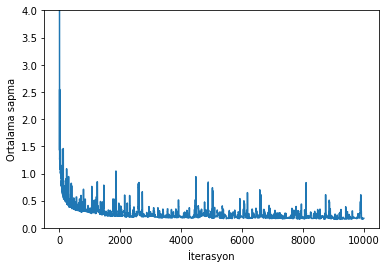

In [8]:
plt.plot(hata_liste)
plt.ylim((0,4))
plt.xlabel("İterasyon")
plt.ylabel("Ortalama sapma");

Görüldüğü gibi, iterasyonlar ilerledikçe, parametreler veriye daha iyi uyuyor ve ortalama sapma düşüyor.

Kolaylık için kodu bir fonksiyon olarak paketleyelim.

In [9]:
def lojreg_stok_iniş(X, y, theta, maxsayac=10000, adımboyu=1000):
    sayac = 0
    hata_liste = [ortsapma(X,y,theta)]
    m = X.shape[0]
    while sayac < maxsayac:
        i = np.random.randint(m)  # rastgele bir veri noktası seç
        theta = theta - (adımboyu/m) * X[i,:] * (model(X[i,:],theta) - y[i])
        hata_liste.append(ortsapma(X,y,theta))
        sayac += 1
    return theta, hata_liste

Daha büyük adımlarla deneyelim.

In [10]:
theta = np.random.randn(n)
theta, hata_liste = lojreg_stok_iniş(Xtrain, ytrain, theta, adımboyu=2000)

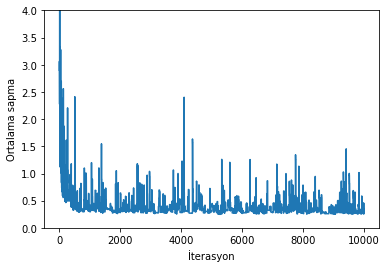

In [11]:
plt.plot(hata_liste)
plt.ylim((0,4))
plt.xlabel("İterasyon")
plt.ylabel("Ortalama sapma");

Görüyoruz ki adım boyunu büyük tutmak, başlangıçta sapmanın hızlıca düşmesine yol açsa da, daha sonra büyük dalgalanmalara yol açıyor. Genel olarak adımların başta büyük, sonra küçük olacak şekilde ayarlanması tavsiye edilir. Yaygın kullanılan bir yöntem, $t$ iterasyonunda adım büyüklüğünü $\alpha_t = \frac{a}{b+t}$ biçiminde değiştirmektir.

**Çalışma**: Yukarıdaki denemelerimizi göz önünde tutarak farklı _a_ ve _b_ parametreleri deneyin, öyle ki, ortalama sapma 10 000 iterasyon içinde yeterli derecede sıfıra yaklaşmış ve dalgalanmalar çok azalmış olsun. Aşağıdaki koddaki boşlukları doldurun.

In [12]:
def lojreg_stok_iniş(X, y, theta, maxsayac=10000):
    sayac = 0
    hata_liste = [ortsapma(X,y,theta)]
    while sayac < maxsayac:
        i = np.random.randint(m)  # rastgele bir veri noktası seç
        adım = 1e6/(10+sayac)
        theta = theta - adım / m * X[i,:] * (model(X[i,:],theta) - y[i])
        hata_liste.append(ortsapma(X,y,theta))
        sayac += 1
    return theta, hata_liste

In [13]:
theta = np.random.randn(n)
theta, hata_liste = lojreg_stok_iniş(Xtrain, ytrain, theta)

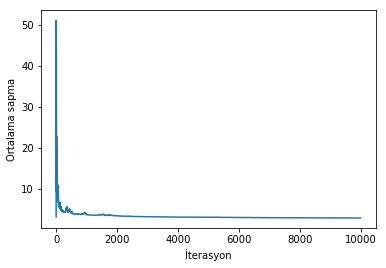

In [14]:
plt.plot(hata_liste)
plt.xlabel("İterasyon")
plt.ylabel("Ortalama sapma");

## Doğrulama

Stokastik iniş kullanarak ortalama sapmayı asgariye indiren $\theta$ parametre vektörünü bulduk. Şimdi, elde ettiğimiz bu vektörün ne kadar başarıyla öğrendiğine bakalım. Bunun için ayrı bir deneme kümesi kullanacağız.

In [15]:
test = np.loadtxt("data/mnist_test_3_8.csv",delimiter=",")

Test verisini öğrenme verisi ile aynı şekilde hazırlayalım.

In [16]:
Xtest = np.copy(test)/test.max() # Veriyi ölçeklendir
Xtest[:,0] = np.ones(Xtest.shape[0]) # Sabit terim için birinci sütuna 1'ler koy.

# y değerlerini, hedeflenen rakama göre 0 veya 1 yap
ytest = np.array([1 if hedef==deger else 0 for hedef in test[:,0]])

Test verisini ve optimum $\theta$ vektörünü model fonksiyonuna vererek, tahminlerden oluşan bir vektör elde ederiz. Hedef vektörü `ytest` sadece 0 ve 1'lerden oluştuğu için, tahminleri de en yakın tamsayıya yuvarlayarak kullanmalıyız.

In [17]:
tahminler = np.rint( model(Xtest,theta) )

Modelin doğruluğunu (_accuracy_) hesaplayalım.

In [18]:
print("Doğruluk =",sum(np.equal( tahminler, ytest)) / len(tahminler) )

Doğruluk = 0.942540322581


## Düzenlileştirme (regülarizasyon)

Aşırı öğrenme (overfitting) problemini önlemek için, hedef fonksiyonuna bir _düzenlileştirme terimi_ eklenir.

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m}\left[ y^{(i)} \log\left(h_\theta(x^{(i)})\right)
+ (1-y^{(i)}) \log\left(1-h_\theta(x^{(i)})\right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$$

Düzenlileştirme teriminde yanlılık terimi $\theta_0$'ın kullanılmadığına dikkat edin. Terimin büyüklüğü $\lambda$ parametresiyle ayarlanır.

Düzenlileştirme terimi eklenince, lojistik regresyon stokastik iniş algoritması şu biçimde olur:

$$
\begin{eqnarray}
\theta_0 &\leftarrow& \theta_0 - \frac{\alpha}{m}  x^{(i)} \left(h_\theta(x^{(i)}) - y^{(i)}\right) \\
\theta_j &\leftarrow& \theta_j - \frac{\alpha}{m}  x^{(i)} \left(h_\theta(x^{(i)}) - y^{(i)}\right) - \frac{\alpha}{m}  \lambda \theta_j \ \ \ \ \ (j>0)
\end{eqnarray}$$



In [19]:
def lojreg_stok_iniş_düz(X, y, theta, lam=1, maxsayac=10000):
    m = X.shape[0]
    sayac = 0
    while sayac < maxsayac:
        i = np.random.randint(m)  # rastgele bir veri noktası seç
        adım = 1e6/(10+sayac)
        theta = theta - adım / m  * X[i,:] * (model(X[i,:],theta) - y[i])
        theta[1:] = theta[1:] - adım / m * lam*theta[1:]
        sayac += 1
    return theta, hata_liste

In [20]:
theta0 = np.random.randn(n)

In [21]:
lam_list = np.arange(0,0.01,0.001)
doğruluk = []
for lam in lam_list:
    theta, hata_liste = lojreg_stok_iniş_düz(Xtrain, ytrain, theta0, lam=lam, maxsayac=20000)
    tahminler = np.rint( model(Xtest,theta) )
    doğruluk.append(sum(np.equal( tahminler, ytest)) / len(tahminler))

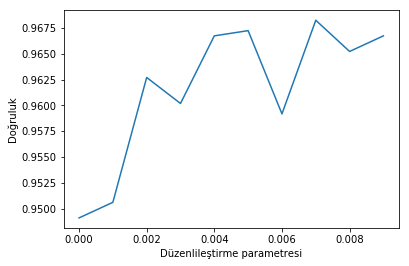

In [22]:
plt.plot(lam_list, doğruluk)
plt.xlabel("Düzenlileştirme parametresi")
plt.ylabel("Doğruluk");

## Mini-yığın yöntemi

Stokastik inişte tek tek veri noktaları almak yerine, her seferinde küçük bir miktar alarak da çalışabiliriz. _Mini-yığın_ (minibatch) denen bu yöntemle daha düzgün bir yakınsama elde edilebilir.

In [23]:
def lojreg_miniyığın(X, y, theta, maxsayac=500, yığın=16):
    sayac = 0
    hata_liste = [ortsapma(X,y,theta)]
    m = X.shape[0]
    while sayac < maxsayac:
        iy = np.random.randint(m,size=yığın)
        yön = np.dot((model(X[iy,:],theta) - y[iy]), X[iy,:]) / yığın
        theta = theta - (1e6/(10+sayac)) / m * yön
        hata_liste.append(ortsapma(X,y,theta))
        sayac += 1
    return theta, hata_liste

In [24]:
theta = np.random.randn(n)
theta, hata_liste = lojreg_miniyığın(Xtrain, ytrain, theta,maxsayac=1000, yığın=200)

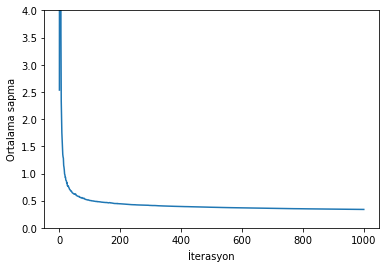

In [25]:
plt.plot(hata_liste)
plt.ylim((0,4))
plt.xlabel("İterasyon")
plt.ylabel("Ortalama sapma");

In [27]:
tahminler = np.rint( model(Xtest,theta) )
print("Doğruluk :",sum(np.equal( tahminler, ytest)) / len(tahminler) )

Doğruluk : 0.963205645161


**Çalışma**: Yığın büyüklüğünü 10-200 arasında değiştirerek parametreleri öğrenin; her biri için test verisine göre doğrulukları hesaplayın. Doğruluğu yığın büyüklüğüne karşı çizdirin.

In [1]:
yığın_list = np.arange(10,201,10)
doğruluk = []
for yığın in yığın_list:
    theta, hata_liste = lojreg_miniyığın(Xtrain, ytrain, theta,maxsayac=1000, yığın=yığın)
    tahminler = np.rint( model(Xtest,theta) )
    doğruluk.append(sum(np.equal( tahminler, ytest)) / len(tahminler))

NameError: name 'np' is not defined

In [ ]:
plt.plot(yığın_list, doğruluk)
plt.xlabel("Yığın büyüklüğü")
plt.ylabel("Doğruluk");

**Ödev** (seçimli): Stokastik inişte, veri içinden rastgele noktaları seçerek hesap yaptık. Başka bir yol, veri noktalarını sırayla almak ve bütün veri setinin üzerinden iki üç kere geçmektir. Bu sayede her bir noktanın kullanılmış olduğundan emin olabiliriz (bunun için veri dosyasının içindeki sıranın rastgele olduğunu varsayıyoruz; öyle değilse önceden bir karıştırma uygulamak gerekir). Bu belgedeki stokastik iniş ve mini-yığın algoritmalarını bu yaklaşımla tekrar yazın.